In [1]:
import torch
import numpy as np
from torch import nn
from torch import optim
from torch.autograd import Variable
import sys

# Define Concrete Dropout

In [2]:
class ConcreteDropout(nn.Module):
    
    def __init__(self, layer, input_shape, wr=1e-6, dr=1e-5, init_min=0.1, init_max=0.1):
        super(ConcreteDropout, self).__init__()
        
        # Post dropout layer
        self.layer = layer
        # Input dim
        self.input_dim = np.prod(input_shape)
        # Regularisation hyper-params
        self.w_reg_param = wr
        self.d_reg_param = dr
        
        # Initialise p_logit
        init_min = np.log(init_min) - np.log(1. - init_min)
        init_max = np.log(init_max) - np.log(1. - init_max)
        
        self.p_logit = nn.Parameter(torch.Tensor(1))
        nn.init.uniform(self.p_logit, a=init_min, b=init_max)
        
    def sum_of_square(self):
        """
        For paramater regularisation
        """
        sum_of_square = 0
        for param in self.layer.parameters():
            sum_of_square += torch.sum(torch.pow(param, 2))
        return sum_of_square
    
    def regularisation(self):
        """
        Returns regularisation term, should be added to the loss
        """
        weights_regularizer = self.w_reg_param * self.sum_of_square() / (1 - self.p)
        dropout_regularizer = self.p * torch.log(self.p)
        dropout_regularizer += (1. - self.p) * torch.log(1. - self.p)
        dropout_regularizer *= self.d_reg_param * self.input_dim
        regularizer = weights_regularizer + dropout_regularizer
        return regularizer
    
    def forward(self, x):
        """
        Forward pass for dropout layer
        """
        eps = 1e-7
        temp = 0.1
        
        self.p = nn.functional.sigmoid(self.p_logit)

        unif_noise = np.random.uniform()

        drop_prob = (torch.log(self.p + eps) 
                    - torch.log(1 - self.p + eps)
                    + np.log(unif_noise + eps)
                    - np.log(1 - unif_noise + eps))
        drop_prob = nn.functional.sigmoid(drop_prob / temp)
        random_tensor = 1 - drop_prob
        retain_prob = 1 - self.p

        x  = torch.mul(x, random_tensor)
        x /= retain_prob
        
        return self.layer(x)
    
class Linear_relu(nn.Module):
    
    def __init__(self, inp, out):
        super(Linear_relu, self).__init__()
        self.model = nn.Sequential(nn.Linear(inp, out), nn.ReLU())
        
    def forward(self, x):
        return self.model(x)

In [3]:
class Model(nn.Module):
    
    def __init__(self, wr, dr):
        super(Model, self).__init__()
        self.forward_main = nn.Sequential(ConcreteDropout(Linear_relu(1, nb_features), input_shape=1, wr=wr, dr=dr),
                                         ConcreteDropout(Linear_relu(nb_features, nb_features), input_shape=nb_features, wr=wr, dr=dr),
                                         ConcreteDropout(Linear_relu(nb_features, nb_features), input_shape=nb_features, wr=wr, dr=dr))
        self.forward_mean = ConcreteDropout(Linear_relu(nb_features, D), input_shape=nb_features, wr=wr, dr=dr)
        self.forward_logvar = ConcreteDropout(Linear_relu(nb_features, D), input_shape=nb_features, wr=wr, dr=dr)
        
    def forward(self, x):
        x = self.forward_main(x)
        mean = self.forward_mean(x)
        log_var = self.forward_logvar(x)
        return mean, log_var

    def heteroscedastic_loss(self, true, mean, log_var):
        precision = torch.exp(-log_var)
        return torch.sum(precision * (true - mean)**2 + log_var)
    
    def regularisation_loss(self):
        reg_loss = self.forward_main[0].regularisation()+self.forward_main[1].regularisation()+self.forward_main[2].regularisation()
        reg_loss += self.forward_mean.regularisation()
        reg_loss += self.forward_logvar.regularisation()
        return reg_loss

# Set up experiment 

In [33]:
Ns = [10, 25, 50, 100, 1000, 10000] # Number of data points
Ns = np.array(Ns)
nb_epochs = [2000, 1000, 500, 200, 20, 2]
nb_val_size = 1000 # Validation size
nb_features = 1024 # Hidden layer size
Q = 1 # Data dimensionality
D = 1 # One mean, one log_var
K_test = 20 # Number of MC samples
nb_reps = 3 # Number of times to repeat experiment
batch_size = 20
l = 1e-4 # Lengthscale
gpu = 1 # GPU id

In [34]:
def gen_data(N):
    """
    Function to generate data
    """
    sigma = 1e0  # ground truth
    X = np.random.randn(N, Q)
    w = 2.
    b = 8.
    Y = X.dot(w) + b + sigma * np.random.randn(N, D)
    return X, Y

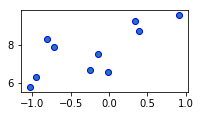

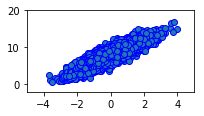

In [35]:
import pylab
%matplotlib inline

X, Y = gen_data(10)
pylab.figure(figsize=(3, 1.5))
pylab.scatter(X[:, 0], Y[:, 0], edgecolor='b')
# pylab.savefig('data_10.pdf', bbox_inches='tight')
pylab.show()

X, Y = gen_data(10000)
pylab.figure(figsize=(3, 1.5))
pylab.scatter(X[:, 0], Y[:, 0], edgecolor='b')
pylab.xlim([-5, 5])
pylab.ylim([-2, 20])
# pylab.savefig('data_10000.pdf', bbox_inches='tight')
pylab.show()

# Define fit and evaluation functions

In [36]:
def fit_model(nb_epoch, X, Y):
    N = X.shape[0]
    wr = l**2. / N
    dr = 2. / N
    
    model = Model(wr, dr)
    model = model.cuda(gpu)
    optimizer = optim.Adam(model.parameters())
    
    for i in range(nb_epoch):
        old_batch = 0
        for batch in range(int(np.ceil(X.shape[0]/batch_size))):
            batch = (batch + 1)
            _x = X[old_batch: batch_size*batch]
            _y = Y[old_batch: batch_size*batch]
            
            x = Variable(torch.FloatTensor(_x).cuda(gpu))
            y = Variable(torch.FloatTensor(_y).cuda(gpu))
            
            mean, log_var = model(x)
            
            loss = model.heteroscedastic_loss(y, mean, log_var) + model.regularisation_loss()
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
    return model

In [37]:
def logsumexp(a):
    a_max = a.max(axis=0)
    return np.log(np.sum(np.exp(a - a_max), axis=0)) + a_max

def test(Y_true, K_test, means, logvar):
    """
    Estimate predictive log likelihood:
    log p(y|x, D) = log int p(y|x, w) p(w|D) dw
                 ~= log int p(y|x, w) q(w) dw
                 ~= log 1/K sum p(y|x, w_k) with w_k sim q(w)
                  = LogSumExp log p(y|x, w_k) - log K
    :Y_true: a 2D array of size N x dim
    :MC_samples: a 3D array of size samples K x N x 2*D
    """
    k = K_test
    N = Y_true.shape[0]
    mean = means 
    logvar = logvar
    test_ll = -0.5 * np.exp(-logvar) * (mean - Y_val.squeeze())**2. - 0.5 * logvar - 0.5 * np.log(2 * np.pi) #Y_true[None]
    test_ll = np.sum(np.sum(test_ll, -1), -1)
    test_ll = logsumexp(test_ll) - np.log(k)
    pppp = test_ll / N  # per point predictive probability
    rmse = np.mean((np.mean(mean, 0) - Y_val.squeeze())**2.)**0.5
    return pppp, rmse

In [38]:
def plot(X_train, Y_train, X_val, Y_val, means):
    indx = np.argsort(X_val[:, 0])
    _, (ax1, ax2, ax3, ax4) = pylab.subplots(1, 4,figsize=(12, 1.5), sharex=True, sharey=True)
    ax1.scatter(X_train[:, 0], Y_train[:, 0], c='y')
    ax1.set_title('Train set')
    ax2.plot(X_val[indx, 0], np.mean(means, 0)[indx], color='skyblue', lw=3)
    ax2.scatter(X_train[:, 0], Y_train[:, 0], c='y')
    ax2.set_title('+Predictive mean')
    for mean in means:
        ax3.scatter(X_val[:, 0], mean, c='b', alpha=0.2, lw=0)
    ax3.plot(X_val[indx, 0], np.mean(means, 0)[indx], color='skyblue', lw=3)
    ax3.set_title('+MC samples on validation X')
    ax4.scatter(X_val[:, 0], Y_val[:, 0], c='r', alpha=0.2, lw=0)
    ax4.set_title('Validation set')
    pylab.show()

# Run the experiment

2000


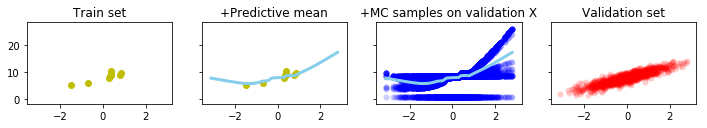

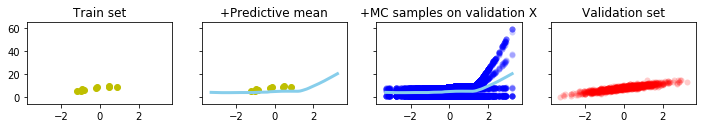

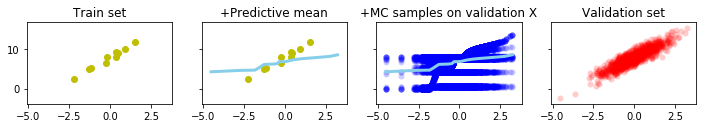

10 2000 - 2.3193581981478246 0.5781171255013444 [0.08370507 0.21109076 0.23299837 0.15326329 0.2896856 ]  -  3.047183759646154 3.2660938273195677
1000


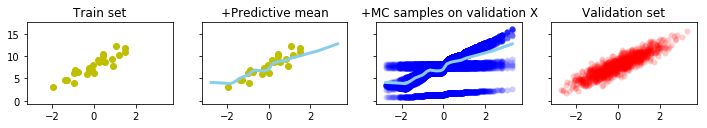

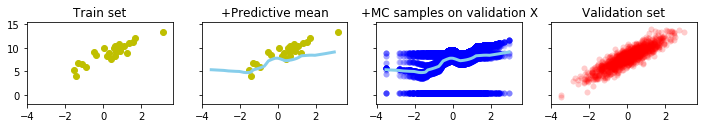

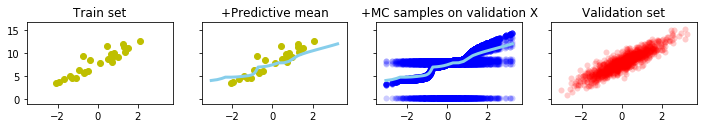

25 1000 - 1.421800084410392 0.14813232153608535 [0.0838556  0.11658484 0.10973147 0.09738889 0.10469636]  -  3.0619649614338873 2.2672992702409096
500


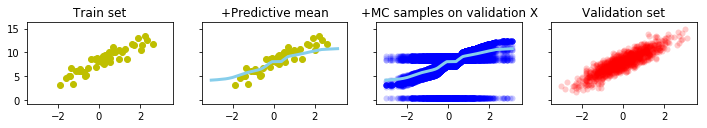

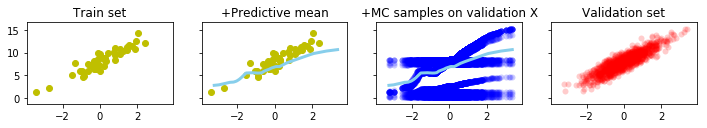

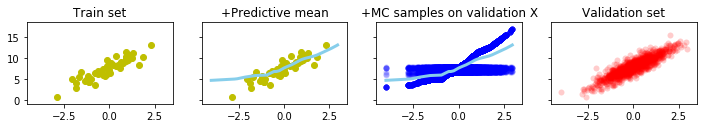

50 500 - 1.341730157424956 0.14866826029497965 [0.08746838 0.09629598 0.09488229 0.08973888 0.13410151]  -  2.576073032244244 2.231386012785645
200


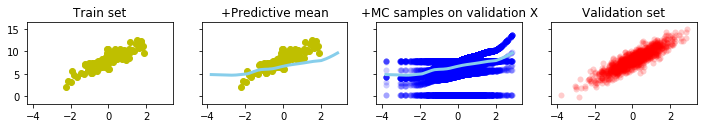

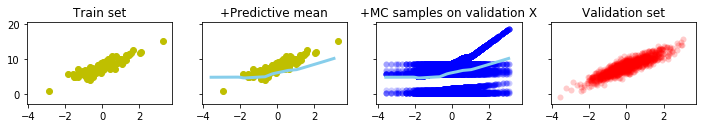

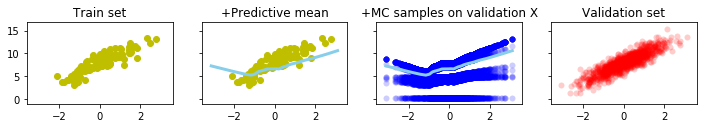

100 200 - 2.180998849410551 0.12263792212600283 [0.09272031 0.09880269 0.0957385  0.0916652  0.09556823]  -  2.7124018603031748 2.789577660947754
20


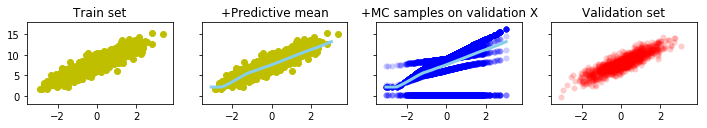

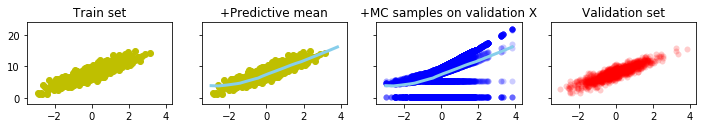

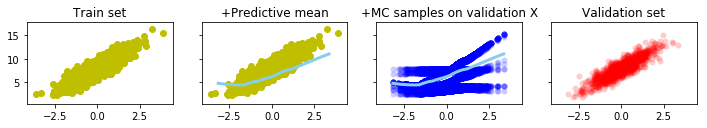

1000 20 - 1.4294829861338172 0.24393516962051137 [0.09099048 0.09706194 0.09416071 0.09130982 0.09526566]  -  5.485765764443363 3.146758812859059
2


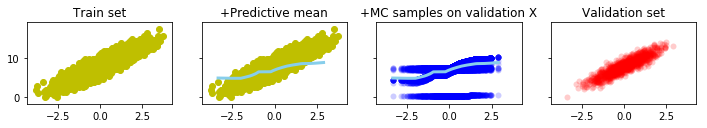

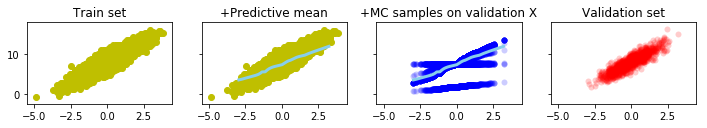

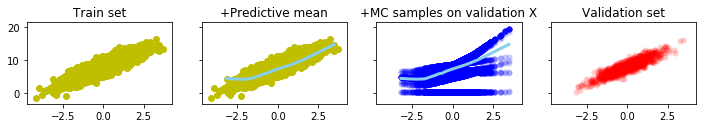

10000 2 - 1.4212716331349917 0.11153300617786537 [0.08804921 0.09428495 0.09221818 0.08719193 0.0947023 ]  -  3.3978317247006693 2.0739735603891183


In [40]:
results = []
for N, nb_epoch in zip(Ns, nb_epochs):
    rep_results = []
    print(nb_epoch)
    for i in range(nb_reps):
        X, Y = gen_data(N + nb_val_size)
        X_train, Y_train = X[:N], Y[:N]
        X_val, Y_val = X[N:], Y[N:]
        model = fit_model(nb_epoch, X_train, Y_train)
        model.eval()
        MC_samples = [model(Variable(torch.FloatTensor(X_val).cuda(gpu))) for _ in range(K_test)]
        means = torch.stack([tup[0] for tup in MC_samples]).view(K_test, X_val.shape[0]).cpu().data.numpy()
        logvar = torch.stack([tup[1] for tup in MC_samples]).view(K_test, X_val.shape[0]).cpu().data.numpy()
        pppp, rmse = test(Y_val, K_test, means, logvar)
        epistemic_uncertainty = np.var(means, 0).mean(0)
        logvar = np.mean(logvar, 0)
        aleatoric_uncertainty = np.exp(logvar).mean(0)
        ps = np.array([module.p.data.cpu().numpy()[0] for module in model.modules() if hasattr(module, 'p')])
        plot(X_train, Y_train, X_val, Y_val, means)
        rep_results += [(rmse, ps, aleatoric_uncertainty, epistemic_uncertainty)]
    test_mean = np.mean([r[0] for r in rep_results])
    test_std_err = np.std([r[0] for r in rep_results]) / np.sqrt(nb_reps)
    ps = np.mean([r[1] for r in rep_results], 0)
    aleatoric_uncertainty = np.mean([r[2] for r in rep_results])
    epistemic_uncertainty = np.mean([r[3] for r in rep_results])
    print(N, nb_epoch, '-', test_mean, test_std_err, ps, ' - ', aleatoric_uncertainty**0.5, epistemic_uncertainty**0.5)
    sys.stdout.flush()
    results += [rep_results]